### Demo fitting the HDFN catalog provided with the original EAZY code

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy
print(eazy.__version__)

# Symlink templates & filters from the eazy-code repository
print('EAZYCODE = '+os.getenv('EAZYCODE'))

eazy.symlink_eazy_inputs() 

0.2.0-17-g70c9360
EAZYCODE = /usr/local/share/eazy-photoz
/usr/local/share/eazy-photoz/templates -> ./templates
/usr/local/share/eazy-photoz/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [3]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

#### Parameters

Default parameters are stored in the file `eazy/data/zphot.param.default` in the repository.

Parameter that differ from defaults can be provided in a dictionary as follows.

In [4]:
params = {}
params['CATALOG_FILE'] = os.path.join(os.getenv('EAZYCODE'), 'inputs/hdfn_fs99_eazy.cat')

params['MAIN_OUTPUT_FILE'] = 'hdfn.eazypy'

# Galactic extinction
params['MW_EBV'] = 0.0103

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 28 # K
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

In [5]:
translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /Users/gbrammer/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /usr/local/share/eazy-photoz/inputs/hdfn_fs99_eazy.cat
f_f300w e_f300w ( 10): hst/wfpc2_f300w.dat
f_f450w e_f450w ( 12): hst/wfpc2_f450w.dat
f_f606w e_f606w ( 14): hst/wfpc2_f606w.dat
f_f814w e_f814w ( 16): hst/wfpc2_f814w.dat
f_irimj e_irimj ( 26): KPNO/IRIMJ
f_irimh e_irimh ( 27): KPNO/IRIMH
f_irimk e_irimk ( 28): KPNO/IRIMK
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Process template tweak_fsps_QSF_12_v3_001.dat.
Process template tweak_fsps_QSF_12_v3_002.dat.
Process template tweak_fsps_QSF_12_v3_003.dat.
Process template tweak_fsps_QSF_12_v3_004.dat.
Process template tweak_fsps_QSF_12_v3_005.dat.
Process template tweak_fsps_QSF_12_v3_006.dat.
Process template tweak_fsps_QSF_12_v3_007.dat.
Process template tweak_fsps_QSF_12_v3_008.dat.
Process template tweak_fsps_QSF_12_v3_009.dat.
Process template tweak_fsps_QSF_12_v3_010.dat.
Process templ

#### Iterative zeropoint corrections

Iteration:  0
Compute best fits
Fit 6.0 s (n_proc=8, NOBJ=645)
Iteration:  1
Compute best fits
Fit 5.5 s (n_proc=8, NOBJ=645)
`error_residuals`: force uncertainties to match residuals


/Users/gbrammer/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Iteration:  2
Compute best fits
Fit 5.7 s (n_proc=8, NOBJ=643)
`error_residuals`: force uncertainties to match residuals


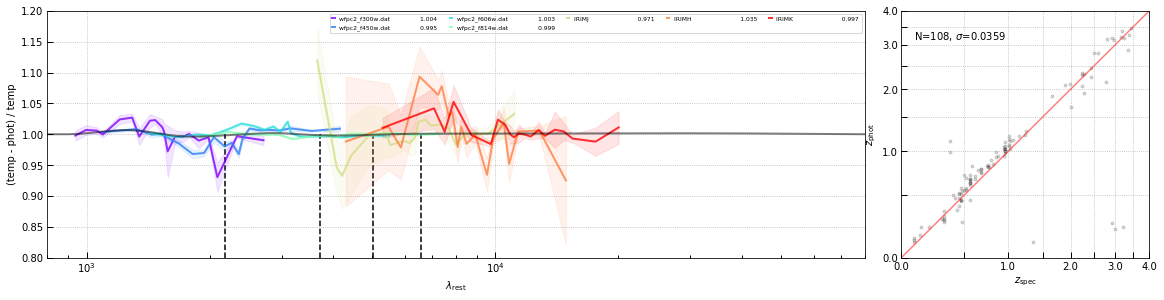

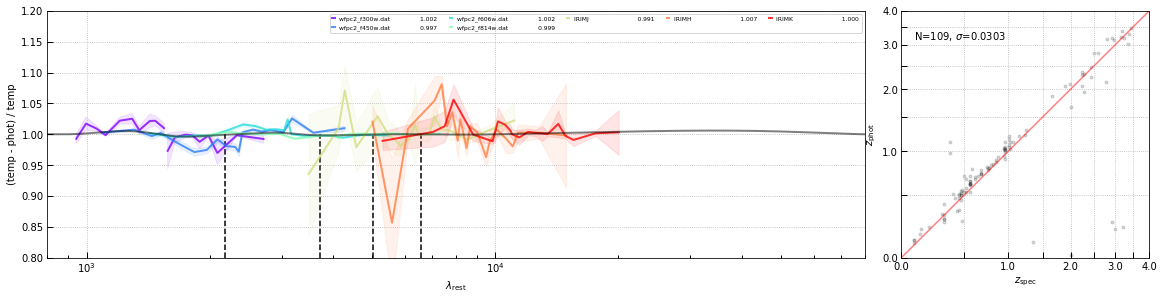

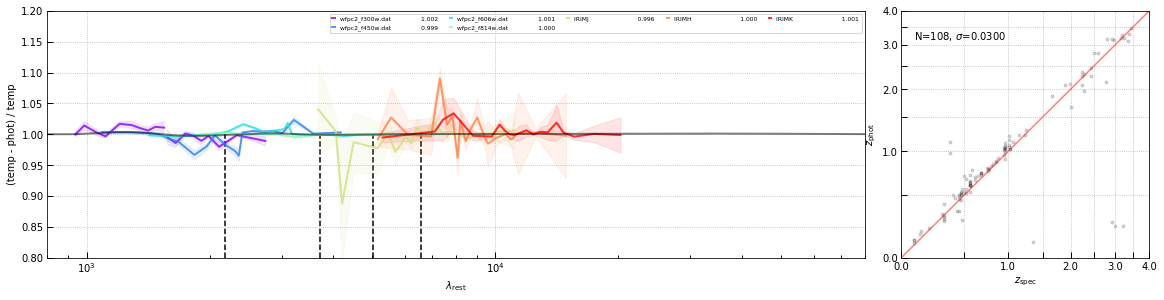

In [6]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    
    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=(iter > 0), 
                              NBIN=NBIN, get_spatial_offset=False)

#### Now fit the whole catalog

In [7]:
# Turn off error corrections derived above
self.efnu = self.efnu_orig*1

# Full catalog
sample = np.isfinite(self.cat['z_spec'])

self.fit_parallel(self.idx[sample], n_proc=8)

Compute best fits
Fit 9.5 s (n_proc=8, NOBJ=1067)


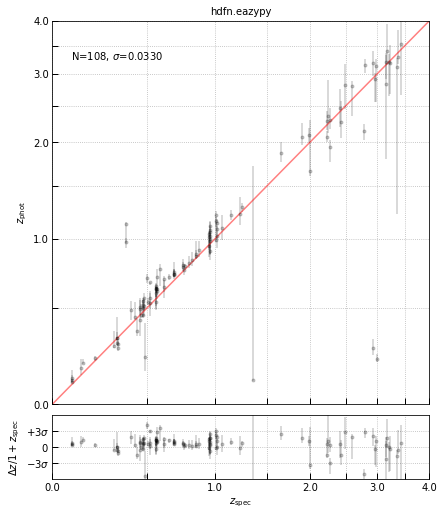

In [8]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [ ]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, 
                                 prior=True, beta_prior=True)

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts


In [ ]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['SFR']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel], 
            vmin=-13, vmax=-8, alpha=0.5)

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')    

In [ ]:
# Show brightest objects with z_spec > 1
imag = params['PRIOR_ABZP'] - 2.5*np.log10(self.cat['f_f814w'])
sel = (self.cat['z_spec'] > 1.1)

so = np.argsort(imag[sel])
ids = self.cat['id'][sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

In [ ]:
# Compare forced fit at z_spec
for i in range(4):
    ix = np.where(self.cat['id'] == ids[i])[0][0]
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], 
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = self.show_fit(ids[i], xlim=[0.2, 3], axes=axes,
                        zshow=self.cat['z_spec'][ix], 
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')